In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

def calculate_pde_eigenvalues(m, n):
    a = 1 / 2
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

In [180]:
class Delaunay_Graph:

    def __init__(self, full_num_Vs, box_side_lengths=[1, 1]):

        self.full_num_Vs = full_num_Vs
        self.box_side_lengths = box_side_lengths
        self.construct_V_coords()
        
    def construct_V_coords(self):

        full_V_coords = np.random.uniform(0 - 0.2, 1 + 0.2, size=(self.full_num_Vs, 2))
        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        # Construct edges
        triangulation = scipy.spatial.Delaunay(full_V_coords)
        V, W = triangulation.vertex_neighbor_vertices
        edges = []
        for v_ind in range(self.full_num_Vs):
            w_inds = W[V[v_ind]:V[v_ind + 1]]
            for w_ind in w_inds:
                if v_ind < w_ind:
                    edges.append([v_ind, w_ind])
        edges = np.array(edges)
        edges = np.sort(edges, axis=1)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.edges = edges
        self.num_Vs = num_Vs
        self.triangulation = triangulation
            
class RGG:

    def __init__(self, full_num_Vs, box_side_lengths=[1, 1]):

        self.full_num_Vs = full_num_Vs
        self.box_side_lengths = box_side_lengths
        self.construct_V_coords()

    def construct_V_coords(self):

        min_coord = -0.2
        max_coord = 1.2

        full_V_coords = np.random.uniform(min_coord, max_coord, size=(self.full_num_Vs, 2))
        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        # Construct edges
        tree = scipy.spatial.cKDTree(full_V_coords)
        mean_l = 2.5 * np.abs(max_coord - min_coord) / np.sqrt(self.full_num_Vs)
        edges = np.array(list(tree.query_pairs(r=mean_l)))
        edges = np.sort(edges, axis=1)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.edges = edges
        self.num_Vs = num_Vs

class Aperiodic_Monotile:

    def __init__(self, N):

        self.construct_V_coords(N)

    def construct_V_coords(self, N):

        file = open("grid_size_150_data/V_coords.pkl", "rb")
        full_V_coords = pickle.load(file)
        file.close()
        file = open("grid_size_150_data/E_lengths_by_v_num.pkl", "rb")
        full_E_lengths_by_v_num = pickle.load(file)
        file.close()

        translate = np.array([0.1, -50.1])
        full_V_coords += translate

        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < N) & (full_V_coords[:, 1] < N))

        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask])) / N

        old_inds = np.concatenate((np.argwhere(bulk_mask).flatten(), np.argwhere(~bulk_mask).flatten()))
        new_inds = np.arange(full_V_coords.shape[0])
        remap = {i: j for i, j in zip(old_inds, new_inds)}

        old_edges = np.array(list(full_E_lengths_by_v_num.keys()))
        self.old_edges = old_edges
        edges = []
        for v_ind, w_ind in old_edges:
            edges.append([remap[v_ind], remap[w_ind]])
        edges = np.array(edges)
        edges = np.sort(edges, axis=1)

        num_Vs = np.sum(bulk_mask)

        # Plot the lines between neighbors
        for i, j in self.edges:
            if i < self.num_Vs and j < self.num_Vs:
                pass

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.edges = edges
        self.num_Vs = num_Vs
        
        # Plot graph
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)

        ax.add_patch(matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='orange', facecolor='none'))

        # Plot the lines between neighbors
        for i, j in self.edges:
            if i < self.num_Vs and j < self.num_Vs:
                point1 = self.full_V_coords[i]
                point2 = self.full_V_coords[j]
                ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'blue', linewidth=1)
        
        ax.scatter(self.full_V_coords[:self.num_Vs, 0], self.full_V_coords[:self.num_Vs, 1], color='blue', s=30, zorder=10)

        plt.show()

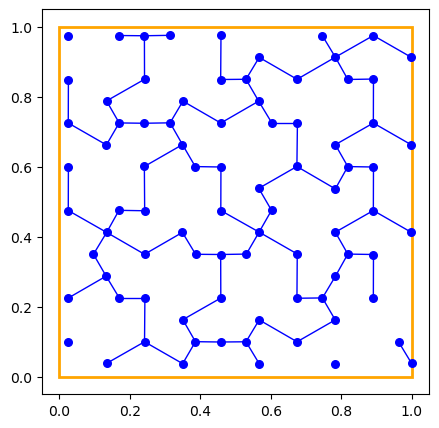

In [181]:
g = Aperiodic_Monotile(4)

In [166]:
class Patch_Graph:
    """
    g needs:
        - num_Vs            : int (number of vertices in bulk)
        - full_V_coords     : Nx2 np.array (first num_Vs are the bulk vertices)
        - edges             : Nx2 np.array (each row must be sorted ascending)
        - box_side_lengths  : list {NOT YET INCLUDED/ASSUMED 1x1 FOR NOW}"""

    def __init__(self, parent_graph):

        self.construct_bulk_and_boundary_attributes(parent_graph)
        print(f"num_Vs = {self.num_Vs}")
        self.construct_boundary_to_bulk_attributes()

        self.construct_NEP_data()
        self.plot_graph(parent_graph)

    def construct_NEP_data(self):

        self.interior_V_num = np.arange(self.num_Vs)
        self.wadjacency_matrices = self.construct_wadjacencies()

    def calculate_csc(self, k, l):
        return 1 / np.sin(k * l)
    
    def calculate_sec(self, k, l):
        return 1 / np.cos(k * l)
    
    def calculate_cot(self, k, l):
        return 1 / np.tan(k * l)

    def calculate_dcsc(self, k, l):
        return -l * self.calculate_csc(k, l) * self.calculate_cot(k, l)

    def calculate_dcot(self, k, l):
        return -l * self.calculate_csc(k, l)**2

    def calculate_dsec(self, k, l):
        return l * self.calculate_sec(k, l) * np.tan(k * l)
    
    def construct_wadjacencies(self):

        wadjacency_matrices = []

        bulk_wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            bulk_wadjacency_matrix[v_ind, w_ind] = l_vw
            bulk_wadjacency_matrix[w_ind, v_ind] = l_vw
        bulk_wadjacency_matrix = bulk_wadjacency_matrix.tocsc()

        wadjacency_matrices.append(bulk_wadjacency_matrix)

        boundary_wadjacency_matrices = []
        for v_ind, w_ind in self.periodic_edges:
            for v_coords, w_coords in self.periodic_edges[v_ind, w_ind]:
                boundary_wadjacency_matrix = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))
                l_vw = np.linalg.norm(v_coords - w_coords)
                boundary_wadjacency_matrix[v_ind, w_ind] = l_vw
                boundary_wadjacency_matrix[w_ind, v_ind] = l_vw
                boundary_wadjacency_matrix = boundary_wadjacency_matrix.tocsc()
                boundary_wadjacency_matrices.append(boundary_wadjacency_matrix)

        wadjacency_matrices += boundary_wadjacency_matrices

        return wadjacency_matrices

    def construct_L(self, k, deriv=False):

        if not deriv:
            calculate_csc = self.calculate_csc
            calculate_cot = self.calculate_cot
        else:
            calculate_csc = self.calculate_dcsc
            calculate_cot = self.calculate_dcot

        L = scipy.sparse.lil_matrix((self.num_Vs, self.num_Vs))

        for wadjacency_matrix in self.wadjacency_matrices[:1]:

            matrix_csc = wadjacency_matrix.copy()
            matrix_csc.data = calculate_csc(k, matrix_csc.data)

            matrix_cot = wadjacency_matrix.copy()
            matrix_cot.data = calculate_cot(k, matrix_cot.data)
            matrix_cot = scipy.sparse.diags(matrix_cot.sum(axis=0).flat)

            L += matrix_cot - matrix_csc

        for wadjacency_matrix in self.wadjacency_matrices[1:]:
            v, w = wadjacency_matrix.nonzero()[0]
            csc = calculate_csc(k, wadjacency_matrix[v, w])
            cot = calculate_cot(k, wadjacency_matrix[v, w])
            L[v, w] -= csc
            L[w, v] -= csc
            L[v, v] += cot
            L[w, w] += cot

        L = L.tocsc()

        return L

    def construct_bulk_and_boundary_attributes(self, parent_graph):

        # Loop through v_ind, w_ind in parent_graph.edges. Construct edges and boundary edges. 
        # Indices are ordered so we know which vertices are in the graph/bulk, and which are boundary.
        # Construct also boundary vertex indices.
        edges = []
        boundary_edges = []
        boundary_V_inds = []
        for v_ind, w_ind in parent_graph.edges:
            if v_ind < parent_graph.num_Vs:
                edge = [v_ind, w_ind]
                if w_ind < parent_graph.num_Vs:
                    edges.append(edge)
                else:
                    w_coords = parent_graph.full_V_coords[w_ind]
                    if (not np.any(w_coords < 0)) or (w_coords[0] > 1 and w_coords[1] < 0):
                        boundary_V_inds.append(w_ind)
                        boundary_edges.append(edge)
        boundary_V_inds = np.unique(boundary_V_inds)
        V_coords = parent_graph.full_V_coords[:parent_graph.num_Vs]
        boundary_V_coords = parent_graph.full_V_coords[boundary_V_inds]
        num_Vs = V_coords.shape[0]
        num_boundary_Vs = boundary_V_coords.shape[0]
        reindex_boundary_V_coords = {i: en for en, i in enumerate(boundary_V_inds)}

        # edges is [v_ind, w_ind] where 0 <= v_ind, w_ind <= num_Vs - 1
        # boundary_edges is [v_ind, w_ind] where 0 <= v_ind <= num_Vs - 1 and 0 <= w_ind <= num_boundary_Vs - 1
        edges = np.array(edges)
        boundary_edges = np.array([[i, reindex_boundary_V_coords[j]] for i, j in boundary_edges])

        # Define bulk attributes
        self.V_coords = V_coords
        self.edges = edges
        self.num_Vs = num_Vs
        # Define boundary attributes
        self.boundary_V_coords = boundary_V_coords
        self.boundary_edges = boundary_edges
        self.num_boundary_Vs = num_boundary_Vs

    def construct_boundary_to_bulk_attributes(self):

        # Construct boundary map
        boundary_to_bulk_map = {}
        for v_ind, v_coords in enumerate(self.boundary_V_coords):
            wrapped_v_coords = v_coords % 1
            distances = np.linalg.norm(self.V_coords - wrapped_v_coords, axis=1)
            wrapped_v_ind = distances.argmin()
            boundary_to_bulk_map[v_ind] = wrapped_v_ind

        periodic_edges = collections.defaultdict(list)
        for v_ind, w_ind in self.boundary_edges:
            bulk_w_ind = boundary_to_bulk_map[w_ind]
            periodic_edges[(v_ind, bulk_w_ind)].append(np.array((self.V_coords[v_ind], self.boundary_V_coords[w_ind])))

        # Define boundary to bulk attributes
        self.boundary_to_bulk_map = boundary_to_bulk_map
        self.periodic_edges = periodic_edges

    def construct_alpha_solve(self):

        LHS = scipy.sparse.lil_matrix((self.num_Vs + 1, self.num_Vs))

        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            LHS[v_ind, w_ind] -= 1 / l_vw
            LHS[w_ind, v_ind] -= 1 / l_vw
            LHS[v_ind, v_ind] += 1 / l_vw
            LHS[w_ind, w_ind] += 1 / l_vw

        for v_ind, w_ind in self.periodic_edges:
            for v_coords, w_coords in self.periodic_edges[v_ind, w_ind]:
                l_vw = np.linalg.norm(v_coords - w_coords)
                LHS[v_ind, w_ind] -= 1 / l_vw
                LHS[w_ind, v_ind] -= 1 / l_vw
                LHS[v_ind, v_ind] += 1 / l_vw
                LHS[w_ind, w_ind] += 1 / l_vw

        RHS = scipy.sparse.lil_matrix((self.num_Vs + 1, 2))
        for v_ind, w_ind in self.periodic_edges:
            for v_coords, w_coords in self.periodic_edges[v_ind, w_ind]:
                l_vw = np.linalg.norm(v_coords - w_coords)
                v_x_coords = self.v_coords_to_x_coords(v_coords)
                w_x_coords = self.v_coords_to_x_coords(w_coords) 
                r_xy = w_x_coords - v_x_coords
                RHS[v_ind] += r_xy / l_vw
                RHS[w_ind] -= r_xy / l_vw

        LHS[-1] = np.ones(self.num_Vs)
        LHS = LHS.tocsc()
        RHS = RHS.tocsc()

        return LHS, RHS

    # def construct_boundary_edges(self):

        # # Construct boundary map
        # boundary_to_bulk_map = {}
        # for v_ind, v_coords in enumerate(boundary_V_coords):
        #     wrapped_v_coords = v_coords % 1
        #     r_xy = v_coords - wrapped_v_coords
        #     distances = np.linalg.norm(V_coords - wrapped_v_coords, axis=1)
        #     wrapped_v_ind = distances.argmin()
        #     boundary_to_bulk_map[v_ind] = [wrapped_v_ind, r_xy]

        # # For remapping bulk to boundary to **update** exact l_vw's
        # periodic_edges = {}
        # for v_ind, w_ind in boundary_edges:
        #     w_ind, w_translation = boundary_to_bulk_map[w_ind]
        #     periodic_edges[(v_ind, w_ind)] = np.array((V_coords[v_ind], V_coords[w_ind] + w_translation))

    def plot_graph(self, parent_graph):

        # Plot graph
        fig = plt.figure(figsize=(9, 9))
        ax = fig.add_subplot(111)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        ax.add_patch(matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='orange', facecolor='none'))

        # Plot the lines between neighbors
        for i, j in self.edges:
            point1 = self.V_coords[i]
            point2 = self.V_coords[j]
            ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'blue', linewidth=1)
        for i, j in self.periodic_edges:
            for point1, point2 in self.periodic_edges[i, j]:
                ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'green', linewidth=1)
        
        # ax.triplot(parent_graph.full_V_coords[:, 0], parent_graph.full_V_coords[:, 1], parent_graph.triangulation.simplices)

        ax.scatter(self.V_coords[:, 0], self.V_coords[:, 1], color='blue', s=30, zorder=10)
        ax.scatter(self.boundary_V_coords[:, 0], self.boundary_V_coords[:, 1], color='red', s=30, zorder=10)

        # for en, v in enumerate(self.V_coords):
        #     ax.annotate(str(en), v, fontsize=20)

        # for en, v in enumerate(self.boundary_V_coords):
        #     ax.annotate(str(en), v, fontsize=20)

    def calculate_l_vw(self, v_ind, w_ind):
        return np.linalg.norm(self.V_coords[v_ind] - self.V_coords[w_ind])

    def v_coords_to_x_coords(self, v_coords):
        x_coords = []
        for d in range(v_coords.shape[0]):
            if v_coords[d] < 0:
                x_coords.append(-0.5)
            elif v_coords[d] < 1:
                x_coords.append(0.5)
            else:
                x_coords.append(1.5)
        x_coords = np.array(x_coords)

        return x_coords

num_Vs = 2069


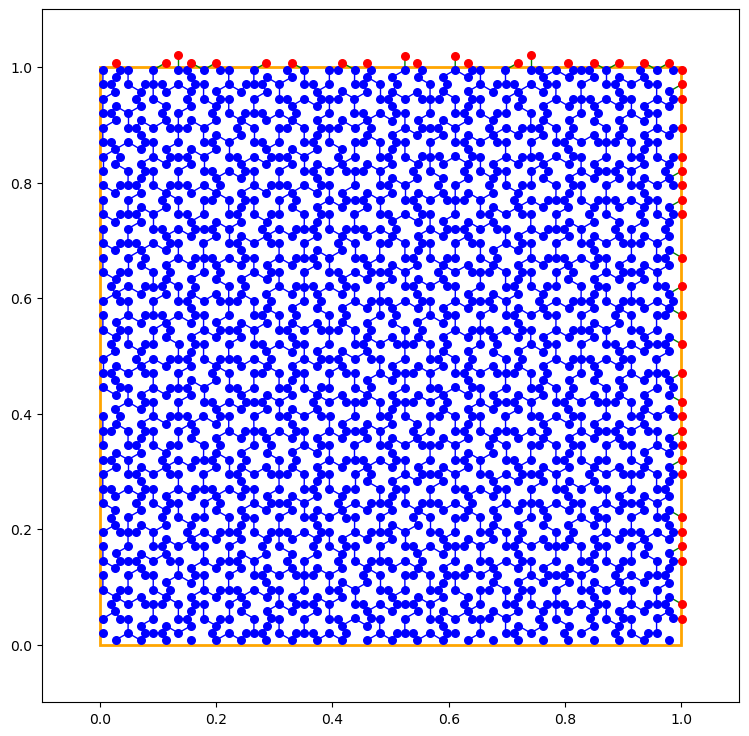

In [172]:
np.random.seed(0)
dg = Aperiodic_Monotile(20)
g = Patch_Graph(dg)

In [176]:
eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)

In [177]:
guesses = np.linspace(2.5, 4.5, 30)
print(guesses)

solutions = eigs(guesses, solve_type="SVD iterate", printerval=1, max_steps=20)

[2.5        2.56896552 2.63793103 2.70689655 2.77586207 2.84482759
 2.9137931  2.98275862 3.05172414 3.12068966 3.18965517 3.25862069
 3.32758621 3.39655172 3.46551724 3.53448276 3.60344828 3.67241379
 3.74137931 3.81034483 3.87931034 3.94827586 4.01724138 4.0862069
 4.15517241 4.22413793 4.29310345 4.36206897 4.43103448 4.5       ]

Calculating eig number 0

Factor is exactly singular
Count = 1
k = 2.5

Factor is exactly singular
Count = 2
k = 0

----------------------
Converged at step 1:

k = 0
----------------------

Calculating eig number 1

Factor is exactly singular
Count = 1
k = 2.5689655172413794

Factor is exactly singular
Count = 2
k = 0

----------------------
Converged at step 1:

k = 0
----------------------

Calculating eig number 2

Factor is exactly singular
Count = 1
k = 2.6379310344827585

Factor is exactly singular
Count = 2
k = 0

----------------------
Converged at step 1:

k = 0
----------------------

Calculating eig number 3

Factor is exactly singular
Count = 

/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_52289/1748869378.py:24: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.sin(k * l)
/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_52289/1748869378.py:30: RuntimeWarning: divide by zero encountered in divide
  return 1 / np.tan(k * l)
/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_52289/1748869378.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / np.sin(k * l)
/var/folders/8c/ybs90zyn3yn3tyx860br5cc40000gn/T/ipykernel_52289/1748869378.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 / np.tan(k * l)


Factor is exactly singular
Count = 2
k = 0

----------------------
Converged at step 1:

k = 0
----------------------

Calculating eig number 7

Factor is exactly singular
Count = 1
k = 2.9827586206896552

Factor is exactly singular
Count = 2
k = 0

----------------------
Converged at step 1:

k = 0
----------------------

Calculating eig number 8

Factor is exactly singular
Count = 1
k = 3.0517241379310347

Factor is exactly singular
Count = 2
k = 0

----------------------
Converged at step 1:

k = 0
----------------------

Calculating eig number 9

Factor is exactly singular
Count = 1
k = 3.1206896551724137

Factor is exactly singular
Count = 2
k = 0

----------------------
Converged at step 1:

k = 0
----------------------

Calculating eig number 10

Factor is exactly singular
Count = 1
k = 3.189655172413793

Factor is exactly singular
Count = 2
k = 0

----------------------
Converged at step 1:

k = 0
----------------------

Calculating eig number 11

Factor is exactly singular
Cou

In [178]:
print(solutions)
print()
print(np.unique(np.round(solutions, 10))[:4])
mean_eig = np.mean(np.unique(np.round(solutions, 10))[:4])
print(mean_eig)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

[0]
0.0


In [6]:
# For 10k RGG
mean_eig = np.mean([3.81421734, 3.93003284, 4.09131297, 3.99457246])

3.9575339025


In [174]:
LHS, RHS = g.construct_alpha_solve()
alpha_x = sparseqr.solve(LHS, RHS[:, 0]) #, tolerance = 1e-9)
alpha_y = sparseqr.solve(LHS, RHS[:, 1]) #, tolerance = 1e-9)
alpha = np.hstack((alpha_x.A, alpha_y.A))
print(f"err = {np.linalg.norm(LHS @ alpha - RHS)}")

err = 1.0872996371801037e-12


In [175]:
Q = np.zeros((2, 2))
T = 0

for v_ind, w_ind in g.edges:
        
    l_vw = g.calculate_l_vw(v_ind, w_ind)
    a_vw = alpha[w_ind] - alpha[v_ind]
    q = np.tensordot(a_vw, a_vw, axes=0) / l_vw
    Q += 2 * q
    T += 2 * l_vw

for v_ind, w_ind in g.periodic_edges:
    for v_coords, w_coords in g.periodic_edges[v_ind, w_ind]:
        l_vw = np.linalg.norm(v_coords - w_coords)
        v_x_coords = g.v_coords_to_x_coords(v_coords)
        w_x_coords = g.v_coords_to_x_coords(w_coords) 
        r_xy = w_x_coords - v_x_coords
        a_vw = r_xy + alpha[w_ind] - alpha[v_ind]
        q = np.tensordot(a_vw, a_vw, axes=0) / l_vw
        Q += 2*q
        T += 2*l_vw

print(Q / T)
print(np.trace(Q / T))
# print(np.trace(Q / T) / 0.921)

[[0.30640449 0.00199905]
 [0.00199905 0.3019123 ]]
0.6083167852537361


In [9]:
def calculate_pde_eigenvalues(m, n):
    a = 1 / 2 
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

In [11]:
calculate_pde_eigenvalues(1, 0) * np.sqrt(np.trace(Q / T)) / mean_eig

1.0034594609760539

In [2]:
class Delaunay_Graph(Graph, Flat):

    def __init__(self, N):

        self.N = N
        self.construct_V_coords(N)
        self.construct_data()
        self.construct_NEP_data()
        self.g_coords = self.construct_g_coords()
        print(f"num_Vs = {self.num_Vs}")
        # self.plot_graph()

    def construct_NEP_data(self):

        interior_V_num = np.arange(self.num_bulk_Vs)
        wadjacency_matrix = scipy.sparse.lil_matrix((self.num_bulk_Vs, self.num_bulk_Vs))
        E_lengths_by_v_num = {}

        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            E_lengths_by_v_num[v_ind, w_ind] = l_vw
            wrapped_v_ind = self.bulk_and_boundary_to_bulk_map[v_ind]
            wrapped_w_ind = self.bulk_and_boundary_to_bulk_map[w_ind]
            wadjacency_matrix[wrapped_v_ind, wrapped_w_ind] = l_vw
            wadjacency_matrix[wrapped_w_ind, wrapped_v_ind] = l_vw

        # Define class attributes
        self.interior_V_num = interior_V_num
        self.E_lengths_by_v_num = E_lengths_by_v_num
        self.wadjacency_matrix = wadjacency_matrix.tocsc()

    def construct_V_coords(self, N):

        full_V_coords = np.random.uniform(0 - 8, 1 + 8, size=(N, 2))

        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_bulk_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        # Construct bulk and boundary edges
        triangulation = scipy.spatial.Delaunay(full_V_coords)
        V, W = triangulation.vertex_neighbor_vertices
        bulk_edges = []
        boundary_edges = []
        boundary_V_inds = []
        for v_ind in range(num_bulk_Vs):
            w_inds = W[V[v_ind]:V[v_ind + 1]]
            for w_ind in w_inds:
                if v_ind < w_ind:
                    if w_ind < num_bulk_Vs:
                        bulk_edges.append([v_ind, w_ind])
                    else:
                        if not np.any(full_V_coords[w_ind] < 0):
                            boundary_edges.append([v_ind, w_ind])
                            boundary_V_inds.append(w_ind)
        bulk_edges = np.array(bulk_edges)
        boundary_edges = np.array(boundary_edges)
        boundary_V_inds = np.unique(boundary_V_inds)

        # Reindex full_V_coords to construct subset: V_coords (just bulk and boundary vertices)
        old_bulk_and_boundary_V_inds = np.concatenate((np.arange(num_bulk_Vs), boundary_V_inds))
        V_coords = full_V_coords[old_bulk_and_boundary_V_inds]

        # Fix indices in bulk and boundary edges. Create full edges
        num_boundary_Vs = boundary_V_inds.shape[0]
        new_bulk_and_boundary_V_inds = np.arange(num_bulk_Vs + num_boundary_Vs)
        old_to_new = {i: j for i, j in zip(old_bulk_and_boundary_V_inds, new_bulk_and_boundary_V_inds)}
        edges = []
        for v_ind, w_ind in np.vstack((bulk_edges, boundary_edges)):
            edges.append([old_to_new[v_ind], old_to_new[w_ind]])
        edges = np.array(edges)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.num_bulk_Vs = num_bulk_Vs
        self.num_boundary_Vs = num_boundary_Vs
        self.V_coords = V_coords
        self.num_Vs = self.V_coords.shape[0]
        self.edges = edges
        self.triangulation = triangulation

    def construct_data(self):

        # Construct boundary map
        bulk_and_boundary_to_bulk_map = {bulk_v_num: bulk_v_num for bulk_v_num in range(self.num_bulk_Vs)}
        for boundary_v_ind in range(self.num_bulk_Vs, self.num_Vs):
            wrapped_w_coord = self.V_coords[boundary_v_ind] % 1
            distances = np.linalg.norm(self.V_coords[:self.num_bulk_Vs] - wrapped_w_coord, axis=1)
            wrapped_v_ind = distances.argmin()
            bulk_and_boundary_to_bulk_map[boundary_v_ind] = wrapped_v_ind

        LHS = scipy.sparse.lil_matrix((self.num_bulk_Vs + 1, self.num_bulk_Vs))
        RHS = np.zeros((self.num_bulk_Vs + 1, 2))
        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            wrapped_v_ind = bulk_and_boundary_to_bulk_map[v_ind]
            wrapped_w_ind = bulk_and_boundary_to_bulk_map[w_ind]
            LHS[wrapped_v_ind, wrapped_w_ind] -= 1 / l_vw
            LHS[wrapped_w_ind, wrapped_v_ind] -= 1 / l_vw
            LHS[wrapped_v_ind, wrapped_v_ind] += 1 / l_vw
            LHS[wrapped_w_ind, wrapped_w_ind] += 1 / l_vw

            r_xy = self.calculate_r_xy(v_ind, w_ind)
            RHS[wrapped_v_ind] += r_xy / l_vw
            RHS[wrapped_w_ind] -= r_xy / l_vw

        LHS[-1] = np.ones(self.num_bulk_Vs)
        LHS = scipy.sparse.csc_matrix(LHS)

        self.LHS = LHS
        self.RHS = RHS
        self.bulk_and_boundary_to_bulk_map = bulk_and_boundary_to_bulk_map

    def plot_graph_manual(self):

        # Plot
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)

        ax.triplot(self.full_V_coords[:, 0], self.full_V_coords[:, 1], self.triangulation.simplices)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        for i in [0]:
            for j in [0]:
                if i == 0 and j == 0: lw = 3
                else: lw = 1
                ax.add_patch(matplotlib.patches.Rectangle((i, j), 1, 1, linewidth=lw, edgecolor='orange', facecolor='none'))

        ax.scatter(self.V_coords[:self.num_bulk_Vs, 0], self.V_coords[:self.num_bulk_Vs, 1], c='b', s=1)
        ax.scatter(self.V_coords[self.num_bulk_Vs:, 0], self.V_coords[self.num_bulk_Vs:, 1], c='r', s=1)

        for en, v in enumerate(self.V_coords):
            ax.annotate(str(en), v, fontsize=20)
            if en > self.num_bulk_Vs - 1:
                ax.scatter(v[0] % 1, v[1] % 1, c='g', s=40, alpha=0.5)
                ax.annotate(str(en), v % 1, fontsize=15, alpha=0.5)

    def calculate_l_vw(self, v_ind, w_ind):
        return np.linalg.norm(self.V_coords[v_ind] - self.V_coords[w_ind])
    
    def calculate_r_xy(self, v_ind, w_ind):
        v_coords = self.V_coords[v_ind]
        w_coords = self.V_coords[w_ind]
        
        v_x_coords = self.v_coords_to_x_coords(v_coords)
        w_x_coords = self.v_coords_to_x_coords(w_coords)

        r_xy = w_x_coords - v_x_coords

        return r_xy

    def v_coords_to_x_coords(self, v_coords):
        x_coords = []
        for d in range(v_coords.shape[0]):
            if v_coords[d] < 0:
                x_coords.append(-0.5)
            elif v_coords[d] < 1:
                x_coords.append(0.5)
            else:
                x_coords.append(1.5)
        x_coords = np.array(x_coords)

        return x_coords


In [3]:
np.random.seed(3)
g = Delaunay_Graph(120000)

num_Vs = 459


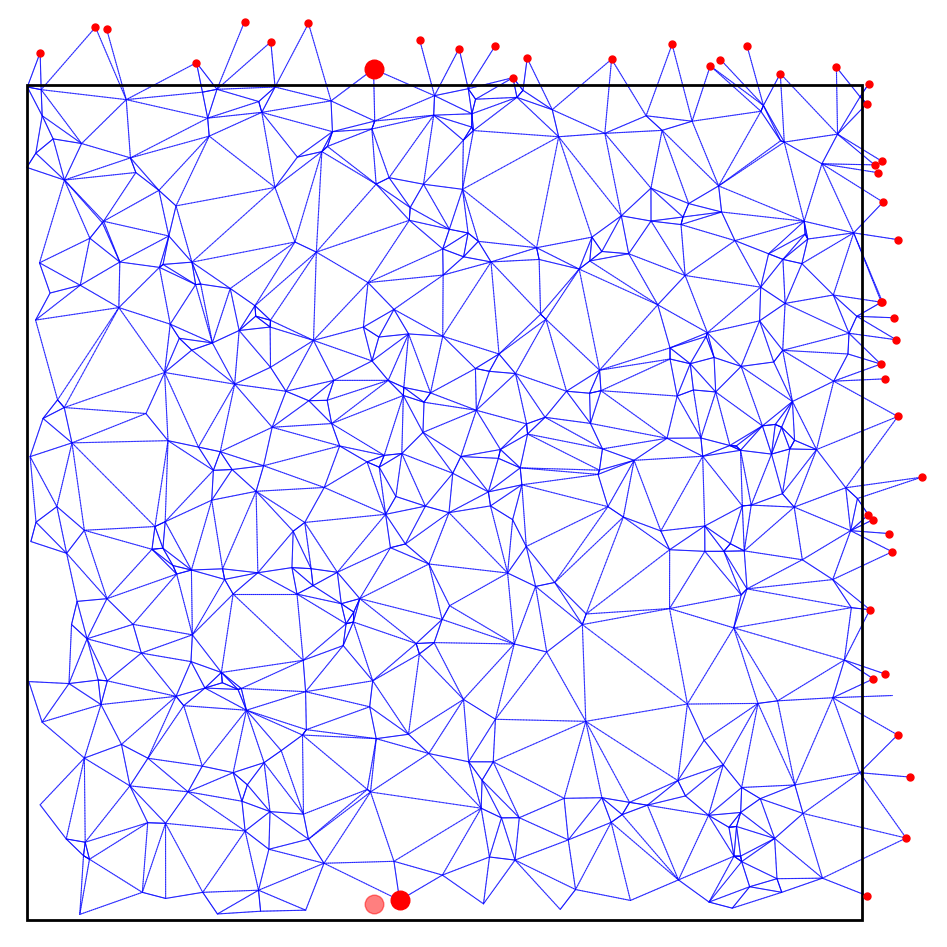

In [42]:
fig, ax = g.plot_graph(return_figax=True, linewidth=0.8, figsize=10, alpha=0.7)
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim(-0.02, 1.09)
ax.set_ylim(-0.02, 1.09)
ax.axis('off')
# ax.triplot(g.full_V_coords[:, 0], g.full_V_coords[:, 1], g.triangulation.simplices, linewidth=1.5)
ax.scatter(g.V_coords[g.num_bulk_Vs:-1, 0], g.V_coords[g.num_bulk_Vs:-1, 1], c='r', s=25, zorder=10, alpha=1)
ax.scatter(g.V_coords[423, 0], g.V_coords[423, 1], c='r', s=180, zorder=10)
ax.scatter(g.V_coords[423, 0] % 1, g.V_coords[423, 1] % 1, c='r', s=180, zorder=10, alpha=0.5)
ax.scatter(g.V_coords[343, 0] % 1, g.V_coords[343, 1] % 1, c='r', s=180, zorder=10)
ax.add_patch(matplotlib.patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='black', facecolor='none', zorder=9))
# plt.savefig("/Users/sidneyholden/Desktop/prx_paper/figs/periodic_patch_graph.png", dpi=200, bbox_inches="tight")
plt.show()

In [23]:
g.bulk_and_boundary_to_bulk_map[423]

343

In [18]:
for en in range(g.num_bulk_Vs, g.num_Vs):
    print(en, g.V_coords[en])
    print()

412 [0.26085319 1.0759915 ]

413 [0.01607319 1.03883589]

414 [1.04100066 0.69508162]

415 [1.02330458 0.74004701]

416 [1.00607339 0.02943247]

417 [1.00827434 1.00181104]

418 [1.04300025 0.60322867]

419 [0.47048852 1.05417145]

420 [1.00951109 0.37184768]

421 [0.56069762 1.04666683]

422 [1.0151179 0.9044614]

423 [0.41528449 1.01920409]

424 [1.01350984 0.47981118]

425 [1.03259321 0.46304289]

426 [0.09577609 1.06669189]

427 [0.81840469 1.02299549]

428 [1.00760634 0.48551193]

429 [0.29225773 1.05173494]

430 [0.59922539 1.03215016]

431 [1.02253399 0.66600722]

432 [1.00580013 0.97765385]

433 [1.07140454 0.53049747]

434 [1.03891297 0.72138424]

435 [0.70026395 1.03098097]

436 [0.77270946 1.04877008]

437 [0.58218817 1.00886917]

438 [1.05736292 0.17149643]

439 [1.02772167 0.6482866 ]

440 [1.02391059 0.90882085]

441 [1.02527844 0.85985175]

442 [1.02453873 0.7404191 ]

443 [1.01868323 0.8952032 ]

444 [1.04273417 0.22192867]

445 [0.96945198 1.02137222]

446 [1.03626784 

In [227]:
eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)

In [234]:
guesses = np.linspace(4.2, 4.5, 10)
print(guesses)

solutions = eigs(guesses, solve_type="SVD iterate", printerval=1, max_steps=20)

[4.2        4.23333333 4.26666667 4.3        4.33333333 4.36666667
 4.4        4.43333333 4.46666667 4.5       ]

Calculating eig number 0

Count = 1
k = 4.2

Count = 2
k = 4.205842821544408

Count = 3
k = 4.205846839821772

Count = 4
k = 4.205846839793892

Count = 5
k = 4.205846839793882

----------------------
Converged at step 4:

k = 4.205846839793887
----------------------

Calculating eig number 1

Count = 1
k = 4.233333333333333

Count = 2
k = 4.258764754971827

Count = 3
k = 4.258841030548946

Count = 4
k = 4.2588410293534835

Count = 5
k = 4.258841029353515

----------------------
Converged at step 4:

k = 4.25884102935352
----------------------

Calculating eig number 2

Count = 1
k = 4.266666666666667

Count = 2
k = 4.274499426290762

Count = 3
k = 4.258812514772088

Count = 4
k = 4.258841029159462

Count = 5
k = 4.258841029353502

Count = 6
k = 4.258841029353515

----------------------
Converged at step 5:

k = 4.258841029353519
----------------------

Calculating eig numbe

In [235]:
print(solutions)
print()
print(np.unique(np.round(solutions, 10))[:4])
print(np.mean(np.unique(np.round(solutions, 10))[:4]))

[4.20584684 4.25884103 4.25884103 4.30467609 4.30467609 4.30467609
 4.30467609 4.30467609 4.30467609 4.30467609]

[4.20584684 4.25884103 4.30467609]
4.256454654300001


In [239]:
calculate_pde_eigenvalues(1, 0) * np.sqrt(0.9223839403920839)

4.266981274294007

In [237]:
alpha_x = sparseqr.solve(g.LHS, g.RHS[:, 0]) #, tolerance = 1e-9)
alpha_y = sparseqr.solve(g.LHS, g.RHS[:, 1]) #, tolerance = 1e-9)
alpha = np.vstack((alpha_x, alpha_y)).T
print(f"err = {np.linalg.norm(g.LHS @ alpha - g.RHS)}")

err = 5.2039891606345235e-11


In [238]:
Q = np.zeros((2, 2))
T = 0

for v_ind, w_ind in g.edges:
        
    l_vw = g.calculate_l_vw(v_ind, w_ind)
    r_xy = g.calculate_r_xy(v_ind, w_ind)

    a_vw = r_xy + alpha[g.bulk_and_boundary_to_bulk_map[w_ind]] - alpha[g.bulk_and_boundary_to_bulk_map[v_ind]]

    q = np.tensordot(a_vw, a_vw, axes=0) / l_vw

    Q += q
    T += l_vw

print(Q / T)
print(np.trace(Q / T))
print(np.trace(Q / T) / 0.93)

[[0.4589656  0.00188199]
 [0.00188199 0.46341834]]
0.9223839403920839
0.9918106885936386
